In [1]:
%load_ext autoreload
%autoreload 2
import jax
import optax as ox
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)
import seaborn as sns
%matplotlib widget
sns.set()
from dataclasses import dataclass, field
from fastHGP.hgp import HGP
from fastHGP.shgp import SHGP, TSHGP 
from fastHGP.kernels import LaplaceBF, SE
key = jr.PRNGKey(13)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
L = 1
M = 10
s2 = 0.1
key, subkey = jr.split(key)
x = jr.uniform(subkey, maxval=2*L, shape=(100,)).sort()-L
key, subkey = jr.split(key)
f = lambda x: jnp.tanh(x*2*jnp.pi) * jnp.sin(x*2*jnp.pi)
# i = 25
# f = lambda x: jnp.sin(jnp.pi * i * (x + L) / (2 * L))
y = f(x) + jnp.sqrt(s2)*jr.normal(subkey, shape=x.shape)
xtest = jnp.linspace(-1, 1, 100)

In [3]:
D = gpx.Dataset(X=x[:, None], y=y[:, None])

bf = LaplaceBF(num_bfs=[50,], L=[1.25])
bf2 = LaplaceBF(num_bfs=7, L=1.25)

likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_noise=jnp.array([s2]))
meanf = gpx.mean_functions.Zero()
kernel = SE(lengthscale=.25, variance=0.5)
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
gp = HGP(prior, likelihood, bf=bf)
gp2 = HGP(prior, likelihood, bf=bf2)
gp3 = SHGP(prior, likelihood, bf=bf)
gp4 = TSHGP(prior, likelihood, bf=bf)

## Selection of BFs test

In [6]:
%pdb on
gpD = gp.update_with_batch(D)
gp2D = gp2.update_with_batch(D)
gp3D = gp3.update_with_batch(D)
gp4D = gp4.update_with_batch(D)

Automatic pdb calling has been turned ON


In [5]:
posterior = prior * likelihood
mll = gpx.objectives.ConjugateMLL(negative=True)
opt, history = gpx.fit(
    model=posterior,
    objective=mll,
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=250,
    safe=True,
    key=key,
)             

  0%|          | 0/250 [00:00<?, ?it/s]

In [10]:
opt.prior.kernel

SE(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(0.22588797, dtype=float32), variance=Array(0.4908992, dtype=float32))

In [6]:
# _, LM, inds = pivoted_chol(gpD.B + , 5)
lambda_j = gpD.bf.eigenvalues()
Lambdainv = jnp.diag(1/gpD.prior.kernel.spectral_density(jnp.sqrt(lambda_j)))
_, LM, inds = pivoted_chol(jnp.linalg.inv(gpD.B + Lambdainv), 5)
inds.sort()
# _, LM, inds = pivoted_chol(gpD.B, 5)

Array([0, 1, 2, 3, 4], dtype=int64)

In [7]:
inds3 = jnp.argsort(jnp.abs(gpD.mean_parameters[0]))[-5:]
inds3.sort()

Array([0, 2, 3, 4, 6], dtype=int64)

In [8]:
inds4 = jnp.argsort(jnp.abs((1/(gpD.B.diagonal() + Lambdainv.diagonal())) * gpD.alpha))[-5:]
inds4.sort()

Array([0, 1, 2, 5, 6], dtype=int64)

In [9]:
_, _, inds2 = pivoted_chol(jnp.diag(1/(gpD.B.diagonal() + Lambdainv.diagonal())), 5)
inds2.sort()

Array([0, 1, 2, 3, 4], dtype=int64)

In [10]:
gp2 = gpD.replace(B=gpD.B[inds[None, :], inds[:, None]], alpha=gpD.alpha[inds], bf=bf.replace(j=inds+1))
gp3 = gpD.replace(B=gpD.B[inds2[None, :], inds2[:, None]], alpha=gpD.alpha[inds2], bf=bf.replace(j=inds2+1))
gp4 = gpD.replace(B=gpD.B[inds3[None, :], inds3[:, None]], alpha=gpD.alpha[inds3], bf=bf.replace(j=inds3+1))
gp5 = gpD.replace(B=gpD.B[inds4[None, :], inds4[:, None]], alpha=gpD.alpha[inds4], bf=bf.replace(j=inds4+1))
# gp2.predict(xtest)

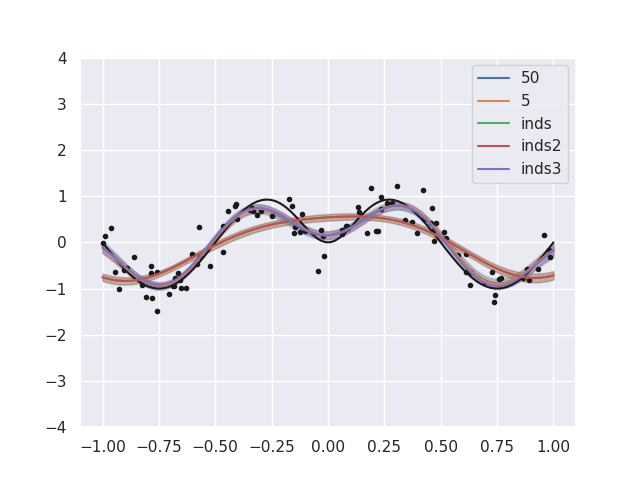

In [11]:
plt.close("all")
plt.figure()
plt.plot(D.X, D.y, '.', color='k')
plt.plot(xtest, f(xtest), color='k')

def conf_int(ax, gp, xtest, label):
    yhat = gp.predict(xtest)
    mu = yhat.mean()
    std = jnp.sqrt(yhat.covariance().diagonal())
    l = ax.plot(xtest, mu, label=label)[0]
    ax.fill_between(xtest, mu+std, mu-std, color=l.get_color(), alpha=.3)

conf_int(plt.gca(), gpD, xtest, "50")
conf_int(plt.gca(), gp2D, xtest, "5")
conf_int(plt.gca(), gp2, xtest, "inds")
conf_int(plt.gca(), gp3, xtest, "inds2")
conf_int(plt.gca(), gp4, xtest, "inds3")
plt.ylim([-4, 4])
plt.legend()
plt.show()

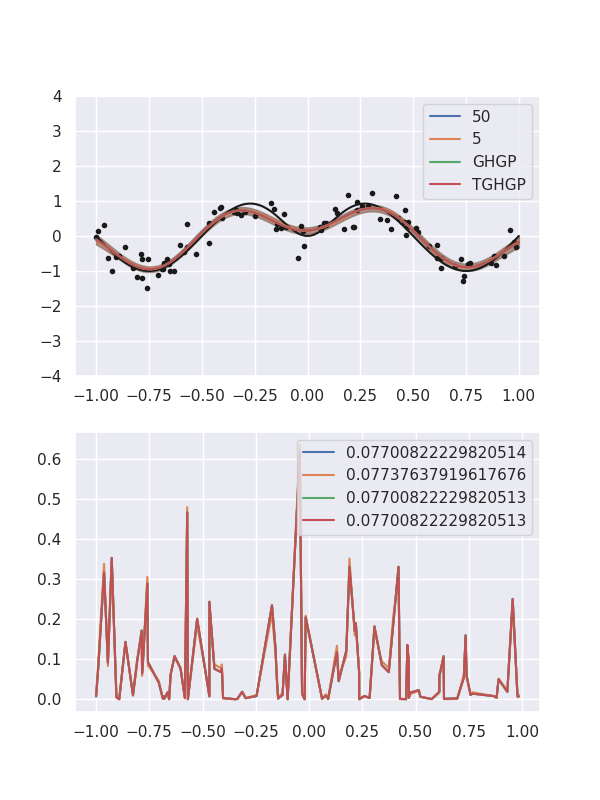

In [12]:
plt.close("all")
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(D.X, D.y, '.', color='k')
ax[0].plot(xtest, f(xtest), color='k')

conf_int(ax[0], gpD, xtest, "50")
conf_int(ax[0], gp2D, xtest, "5")
conf_int(ax[0], gp3D, xtest, "GHGP")
conf_int(ax[0], gp4D, xtest, "TGHGP")
# conf_int(ax[0], gp2, xtest, "inds")
# conf_int(ax[0], gp3, xtest, "inds2")
# conf_int(ax[0], gp4, xtest, "inds3")
# conf_int(ax[0], gp5, xtest, "inds4")
ax[0].set_ylim([-4, 4])
ax[0].legend()

for gpi in [gpD, gp2D, gp3D, gp4D]:#gp2, gp3, gp4, gp5]:
    e = D.y.flatten() - gpi.predict(D.X).mean()
    ax[1].plot(D.X, e**2, label='{}'.format(jnp.mean(e**2)))
ax[1].legend()
plt.show()

In [172]:
import pdb
import jax.scipy as jsp
yhat = gp_mu.predict(xtest)
# jnp.sum(likelihood.expected_log_likelihood(f(xtest)[:,None], yhat.mean(), yhat.covariance().diagonal()))

def sll(gp, Dtest, Dtrain):
    q = gp.predict(Dtest.X)
    m, S = q.mean(), q.covariance().diagonal()
    loss_model = (0.5 * jnp.log(2 * jnp.pi * S) + (Dtest.y.flatten() - m)**2 / (2 * S)).mean()
    res = loss_model
    data_mean = Dtrain.y.mean()
    data_var = Dtrain.y.var()
    loss_trivial_model = (
        0.5 * jnp.log(2 * jnp.pi * data_var) + (Dtest.y.flatten() - data_mean)**2 / (2 * data_var)
    ).mean()
    res = res - loss_trivial_model
    return res

def nlpd(gp, Dtest):
    q = gp.predict(Dtest.X)
    return jnp.mean(-likelihood.link_function(q.mean()).log_prob(Dtest.y.flatten()))

def kl(q1, q2):
    m1, S1 = q1.mean(), q1.covariance()
    m2, S2 = q2.mean(), q2.covariance()
    k = m1.shape[0]
    R1,_ = jsp.linalg.cho_factor(S1 + jnp.identity(k)*likelihood.obs_noise, lower=True)
    R2,_ = jsp.linalg.cho_factor(S2 + jnp.identity(k)*likelihood.obs_noise, lower=True)
    tr_term = jnp.trace(jsp.linalg.cho_solve((R2, True), R1))
    log_det_term = 2 * jnp.sum(jnp.log(R2.diagonal())) - 2 * jnp.sum(jnp.log(R1.diagonal()))
    diff = m1 - m2
    quad_term = diff @ jsp.linalg.cho_solve((R2, True), diff)
    return 1/2 * (tr_term - k + quad_term + log_det_term)

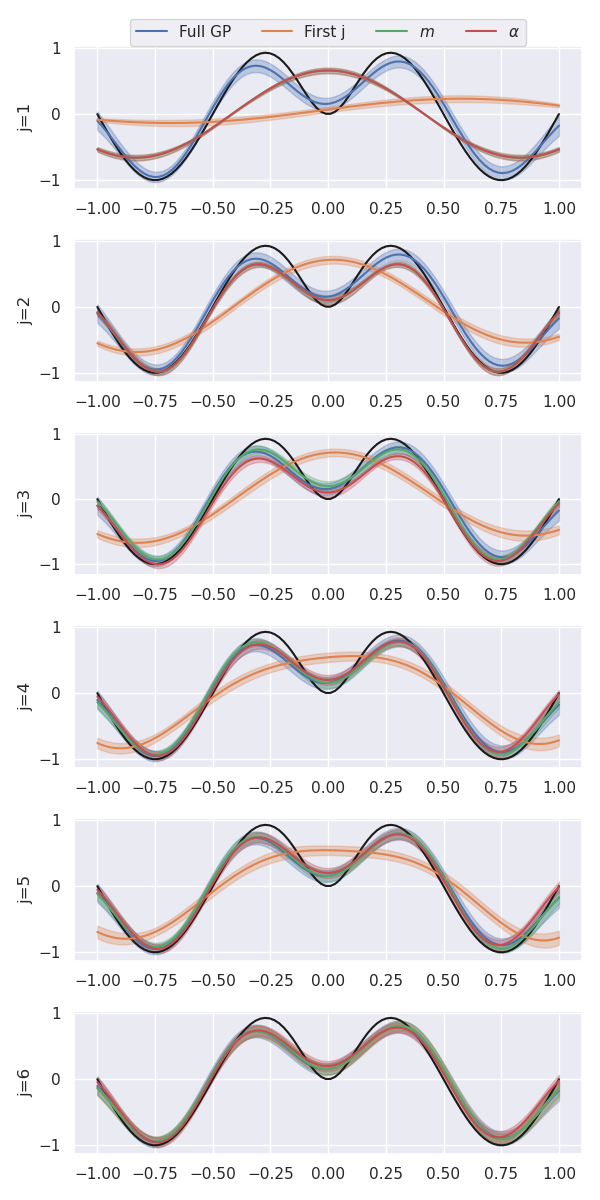

In [182]:
plt.close("all")
J = 7
fig, ax = plt.subplots(J-1, 1, figsize=(6, (J-1)*2))
metrics = {'rmse': {}, 'sll': {}, 'nlpd': {}, 'kl': {}}
fx = f(xtest)
lambda_j = gpD.bf.eigenvalues()
Lambdainv = jnp.diag(1/gpD.prior.kernel.spectral_density(jnp.sqrt(lambda_j)))

for j in range(1, J):
    # True function
    ax[j-1].plot(xtest, fx, 'k')
    # Full GP
    conf_int(ax[j-1], gpD, xtest, "Full GP")
    for key in metrics.keys():
        metrics[key]['j={}'.format(j)] = {}
    # Choose first j 
    baseline = jnp.arange(j+1)
    mean = jnp.argsort(jnp.abs(gpD.mean_parameters.mean()))[-j:].sort()
    alpha = jnp.argsort(jnp.abs((1/(gpD.B.diagonal() + Lambdainv.diagonal())) * gpD.alpha))[-j:].sort()
    inds = [baseline, mean, alpha]
    labels = ["First j", "$m$", r"$\alpha$"]
    for i, ind in enumerate(inds):
        gpi = gpD.replace(B=gpD.B[ind[None,:], ind[:,None]], alpha=gpD.alpha[ind], bf=bf.replace(j=ind+1))
        itest = gpi.predict(xtest)
        iX = gpi.predict(D.X)
        e = fx - itest.mean()
        ell = jnp.mean(likelihood.expected_log_likelihood(D.y, iX.mean(), iX.covariance().diagonal()))
        metrics['rmse']['j={}'.format(j)][labels[i]] = jnp.sqrt(jnp.mean(e**2))
        metrics['nlpd']['j={}'.format(j)][labels[i]] = nlpd(gpi, gpx.Dataset(xtest[:,None], fx[:,None]))
        metrics['sll']['j={}'.format(j)][labels[i]] = sll(gpi, gpx.Dataset(xtest[:,None], fx[:,None]), D)
        metrics['kl']['j={}'.format(j)][labels[i]] = kl(itest, gpD.predict(xtest))
        conf_int(ax[j-1], gpi, xtest, labels[i])
    if j == 1:
        ax[j-1].legend(bbox_to_anchor=[0.5, 0.95], loc="lower center", ncols=4)
    ax[j-1].set(ylabel="j={}".format(j))
plt.tight_layout()
plt.show()
    

In [186]:
pd.DataFrame(metrics['rmse']).T
pd.DataFrame(metrics['nlpd']).T
pd.DataFrame(metrics['sll']).T
pd.DataFrame(metrics['kl']).T

,First j,$m$,$\alpha$
j=1,189.53169187638682,132.98710330936478,132.98710330936478
j=2,131.65431780262324,106.39699623724148,106.39699623724148
j=3,131.50644100374382,104.41166097554905,106.2000042022518
j=4,126.50411925664862,103.71534013448002,104.1926007661278
j=5,126.38418261372905,103.53198294339249,104.10961031337767
j=6,103.21763025320074,103.3182001588672,104.02947287223941


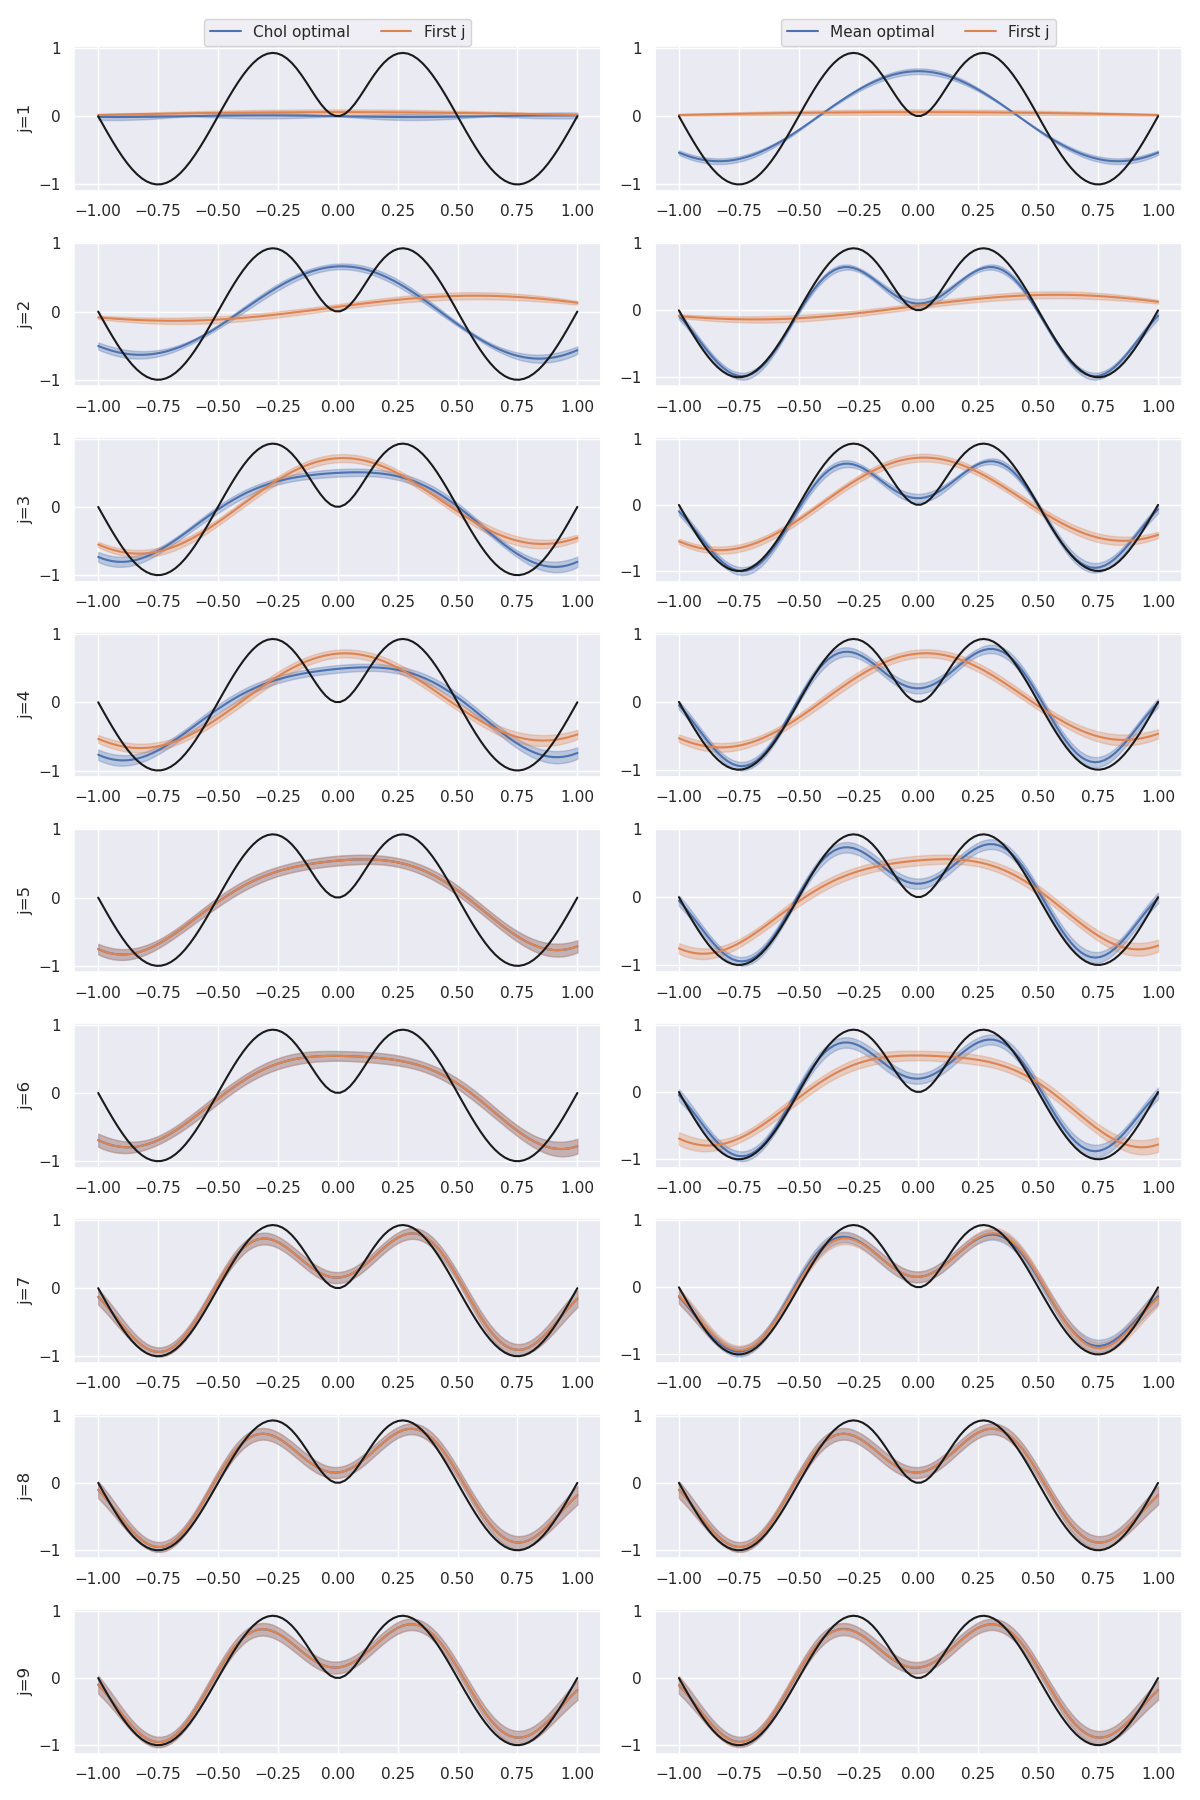

In [76]:
import pandas as pd
J = 10
fig, ax = plt.subplots(J-1, 2, figsize=(12, (J-1)*2))
rmse = {}
fx = f(xtest)
D2 = jnp.linalg.inv(gpD.B + Lambdainv)
for j in range(1, J):
    gpi = gpD.replace(B=gpD.B[:j, :j], alpha=gpD.alpha[:j], bf=bf.replace(j=jnp.arange(1, j+1)))
    yi = gpi.predict(xtest)
    e = fx - yi.mean()
    _, _, inds2 = pivoted_chol(D2, j)
    chol_inds = inds2.sort()
    
    mu_inds = jnp.argsort(jnp.abs(gpD.mean_parameters.mean()))[-j:].sort()
    mu_inds = jnp.argsort(jnp.abs((1/(gpD.B.diagonal() + Lambdainv.diagonal())) * gpD.alpha))[-j:].sort()
    
    gp_chol = gpD.replace(B=gpD.B[chol_inds[None, :], chol_inds[:, None]], alpha=gpD.alpha[chol_inds], bf=bf.replace(j=chol_inds+1))
    gp_mu = gpD.replace(B=gpD.B[mu_inds[None, :], mu_inds[:, None]], alpha=gpD.alpha[mu_inds], bf=bf.replace(j=mu_inds+1))
    y_chol = gp_chol.predict(xtest)
    y_mu = gp_mu.predict(xtest)
    e_chol = fx - y_chol.mean()
    e_mu = fx - y_mu.mean()
    rmse['j={}'.format(j)] = [jnp.sqrt(jnp.mean(e**2)), jnp.sqrt(jnp.mean(e_chol**2)), jnp.sqrt(jnp.mean(e_mu**2))]
    conf_int(ax[j-1, 0], gp_chol, xtest, "Chol optimal".format(j))
    conf_int(ax[j-1, 1], gp_mu, xtest, "Mean optimal".format(j))
    for i in range(2):
        conf_int(ax[j-1, i], gpi, xtest, "First j".format(j))
        ax[j-1, i].plot(xtest, fx, 'k')
        if j == 1:
            ax[j-1, i].legend(bbox_to_anchor=[0.5, 0.95], loc="lower center", ncols=2)
    ax[j-1, 0].set(ylabel="j={}".format(j))
plt.tight_layout()
plt.show()
    

## Fast selection of BFs

In [478]:
from itertools import combinations_with_replacement, product
from hgp import HGP
from gpjax.base import param_field, static_field
from gpjax.typing import ScalarFloat
from jaxtyping import Float, Array

@dataclass 
class GHGP(gpx.gps.AbstractPosterior):
    bf: LaplaceBF = param_field(default=None, trainable=False)
    jitter: ScalarFloat = static_field(1e-6)
    alpha: Float[Array, "M"] = param_field(jnp.zeros((1,)), trainable=False)
    Gamma: Float[Array, "M**D"] = param_field(jnp.zeros((1,)), trainable=False)
    def __post_init__(self):
        m = self.bf.num_bfs
        D = len(m)
        self.alpha = jnp.zeros((jnp.prod(m),))
        self.p = jnp.array(list(product(*[[-1, 1]]*D))) # permutations
        self.unique_k = jnp.array(list(product(*[jnp.arange(1-mi, 2*mi+1) for mi in m])))
        d = int(jnp.ceil(self.unique_k.shape[0]**(1/D)))
        self.Gamma = jnp.zeros((self.unique_k.shape[0],))

    def predict(self, test_inputs):
        qu = self.mean_parameters
        return hgp.predict(qu, self.bf, test_inputs)

    def update_with_batch(self, data):
        g = gamma(data.X, self.unique_k, self.bf.L)
        Phi = self.bf(data.X)
        alpha = jnp.matmul(Phi.T, data.y).squeeze()
        return self.replace(Gamma=self.Gamma + g.reshape(self.Gamma.shape), 
                            alpha=self.alpha + alpha)

    @property
    def B(self):
        indices = jnp.array(list(product(*self.bf.j)))
        return sym(B_triu(self.Gamma, indices, self.bf.num_bfs, self.p))

    @property
    def B_diag(self):
        indices = jnp.array(list(product(*self.bf.j)))
        return B_diag(self.Gamma, indices, self.bf.num_bfs, self.p)

    @property
    def dual_parameters(self):
        return (self.alpha, self.B)

    @property
    def mean_parameters(self):
        return hgp.dual_to_mean(self.alpha, self.B, self.bf, self.prior.kernel.spectral_density, self.likelihood.obs_noise)
    

@dataclass
class TGHGP(GHGP):
    def __post_init__(self):
        m = self.bf.num_bfs
        D = len(m)
        self.alpha = jnp.zeros((jnp.prod(m),))
        self.p = jnp.array(list(product(*[[-1, 1]]*D))) # permutations
        self.unique_k = jnp.array(list(product(*[jnp.arange(1-mi, 2*mi+1) for mi in m])))
        d = int(jnp.ceil(self.unique_k.shape[0]**(1/D)))
        self.Gamma = jnp.zeros([d]*D)

    @property
    def B(self):
        indices = jnp.array(list(product(*self.bf.j)))
        return sym(TB_triu(self.Gamma, indices, self.bf.num_bfs, self.p))

    @property
    def B_diag(self):
        indices = jnp.array(list(product(*self.bf.j)))
        return TB_diag(self.Gamma, indices, self.bf.num_bfs, self.p)

@jax.jit
def gamma(x, ks, Ld):
    # Compute all possible gammas
    return jnp.prod(1/Ld) * jnp.sum(vxgamma(x, Ld, ks), axis=0)

from functools import partial
@jax.jit
def TT_gamma(Gamma, md, i, j, p):
    # Given a particular i and j, extract the relevant Gammas
    k = i + p * j
    c = jnp.prod(p, axis=1)
    # Slicing doesn't work for JIT:ed things -- the slices can't be calculated unfortunately
    # slices = get_slice(k - (1 - md))
    # return c @ Gamma_t[slices].flatten()
    return c @ Gamma[*(k - (1 - md)).T]

def TB_triu(Gamma, indices, md, p):
    # Creates an array with all possible permutations between indices (since I is symmetric we only need to compute the upper triangular part)
    # Assume a matrix A=[a1; a2; a3], combinations_with_replacement creates all possible combinations of a1, a2, a3, assuming that the combinations
    # are "symmetric". I.e., combinations_with_replacement(A) = [(a1, a1), (a1, a2), (a1, a3), (a2, a2), (a2, a3), (a3, a3)].
    # E.g., (a2, a1) is ignored because (a1, a2) exists.
    tmp = jnp.array(list(combinations_with_replacement(indices, 2)))
    i, j = tmp[:, 0], tmp[:, 1] # Extract the two index matrices
    return jax.vmap(TT_gamma, (None, None, 0, 0, None), 0)(Gamma, md, i, j, p)

def TB_diag(Gamma, indices, md, p):
    return jax.vmap(TT_gamma, (None, None, 0, 0, None), 0)(Gamma, md, indices, indices, p)

@jax.jit
def T_gamma(Gamma, md, i, j, p):
    # Given a particular i and j, extract the relevant Gammas
    k = i + p * j
    c = jnp.prod(p, axis=1)
    indices = jax.vmap(ind, (0, None), 0)(k, md)
    return c @ Gamma[indices]

# Computes upper triangular part of the information/dual matrix
def B_triu(Gamma, indices, md, p):
    # Creates an array with all possible permutations between indices (since I is symmetric we only need to compute the upper triangular part)
    # Assume a matrix A=[a1; a2; a3], combinations_with_replacement creates all possible combinations of a1, a2, a3, assuming that the combinations
    # are "symmetric". I.e., combinations_with_replacement(A) = [(a1, a1), (a1, a2), (a1, a3), (a2, a2), (a2, a3), (a3, a3)].
    # E.g., (a2, a1) is ignored because (a1, a2) exists.
    tmp = jnp.array(list(combinations_with_replacement(indices, 2)))
    i, j = tmp[:, 0], tmp[:, 1] # Extract the two index matrices
    return jax.vmap(T_gamma, (None, None, 0, 0, None), 0)(Gamma, md, i, j, p)

def B_diag(Gamma, indices, md, p):
    return jax.vmap(T_gamma, (None, None, 0, 0, None), 0)(Gamma, md, indices, indices, p)

# Theta computation
theta = lambda x, i, L: jnp.pi * i * (x + L) / (2 * L) - jnp.pi / 2
# Gamma computation for a **particular** k
def gamma_k(x, Ls, kis):
    """
    x - 1d vector -- particular data point
    Ls - a vector of Ld, d=1,...,D (1 x D)
    Kis - a vector kd, d=1,...,D (1 x D)
    """
    D = len(kis)
    return 1 / (2 ** D) * jnp.prod(jnp.sin(theta(x, kis, Ls)))
# Vectorized over different k
vkgamma = jax.vmap(gamma_k, (None, None, 0), 0)
# Vectorized over x and k
vxgamma = jax.jit(jax.vmap(vkgamma, (0, None, None), 0))
# Create a symmetric matrix given a triangular part of a matrix
def sym(triu):
    m = int(jnp.sqrt(2*triu.shape[0] + 1/4) - 1/2)
    K = jnp.zeros((m, m))
    K = K.at[jnp.triu_indices(m)].set(triu)
    K += K.T
    return K - jnp.diag(K.diagonal()) / 2

def ind(k, md):
    index = 0
    D = len(md)
    tmp = jnp.flip(jnp.cumprod(3*md[1:]))
    c = jnp.concatenate([tmp, jnp.array([1])])
    return c @ (k - (1 - md))
    # for i in range(D-1):
    #     index += 3**(D-(i+1)) * jnp.prod(md[i+1:]) * (k[i] - (1 - md[i]))
    # return index + (k[-1] - (1 - md[-1]))

In [86]:
key = jr.PRNGKey(13)
x3d = jr.uniform(key, shape=(300,3))*2-1

Ls = jnp.array([1.25, 1.25, 1.25])
ms = jnp.array([10, 10, 10])
bf = LaplaceBF(num_bfs=ms, L=Ls)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=x3d.shape[0], obs_noise=jnp.array([0.01]))
meanf = gpx.mean_functions.Zero()
kernel = SE(lengthscale=.5, variance=0.39)
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
fprior = gpx.Prior(mean_function=meanf, kernel=gpx.kernels.RBF(lengthscale=jnp.ones(3,)*.5, variance=0.25))
gp = SHGP(prior, likelihood, bf=bf)
Tgp = TSHGP(prior, likelihood, bf=bf)
ogp = HGP(prior, likelihood, bf=bf)

f = fprior.sample_approx(num_samples=1, key = key)
y3d = f(x3d)
D = gpx.Dataset(X=x3d, y=y3d)

In [102]:
import timeit
# jnp.std(jnp.array(timeit.repeat('gp.predict(x3d)', repeat=5, number=5, globals=globals())))
# %timeit -r 5 -n 5 gp.predict(x3d)
type(gp).__name__

'HGP'

In [5]:
gp = gp.update_with_batch(D)
Tgp = Tgp.update_with_batch(D)
ogp = ogp.update_with_batch(D)

In [34]:
import jax.scipy as jsp
def sll(q, Dtest, Dtrain):
    m, S = q.mean(), q.covariance().diagonal()
    loss_model = (0.5 * jnp.log(2 * jnp.pi * S) + (Dtest.y.flatten() - m)**2 / (2 * S)).mean()
    res = loss_model
    data_mean = Dtrain.y.mean()
    data_var = Dtrain.y.var()
    loss_trivial_model = (
        0.5 * jnp.log(2 * jnp.pi * data_var) + (Dtest.y.flatten() - data_mean)**2 / (2 * data_var)
    ).mean()
    res = res - loss_trivial_model
    return res

def nlpd(q, Dtest):
    return jnp.mean(-likelihood.link_function(q.mean()).log_prob(Dtest.y.flatten()))

def kl(q1, q2):
    m1, S1 = q1.mean(), q1.covariance()
    m2, S2 = q2.mean(), q2.covariance()
    k = m1.shape[0]
    R1,_ = jsp.linalg.cho_factor(S1 + jnp.identity(k)*likelihood.obs_noise, lower=True)
    R2,_ = jsp.linalg.cho_factor(S2 + jnp.identity(k)*likelihood.obs_noise, lower=True)
    tr_term = jnp.trace(jsp.linalg.cho_solve((R2, True), R1))
    log_det_term = 2 * jnp.sum(jnp.log(R2.diagonal())) - 2 * jnp.sum(jnp.log(R1.diagonal()))
    diff = m1 - m2
    quad_term = diff @ jsp.linalg.cho_solve((R2, True), diff)
    return 1/2 * (tr_term - k + quad_term + log_det_term)

In [113]:
import numpy as np
dat = np.load("outputs/2023-11-22/12-55-53/aresult.npz")


In [87]:
from timeit import timeit
mi = jnp.arange(2, 5)
times = {'HGP': [], 'SHGP': [], 'TSHGP': [], 'AHGP': [], 'ASHGP': [], 'ATSHGP': []}
results = {}
models = {'SHGP': SHGP, 'TSHGP': TSHGP, 'HGP': HGP}
for m in mi:
    ms = jnp.ones((3,), dtype=int) * m
    bf = LaplaceBF(num_bfs=ms, L=Ls)
    for name, cls in models.items():
        if name not in results.keys():
            results[name] = {'SLL': [], 'RMSE': [], 'NLPD': [], 'KL': [], 'Prediction time': [], 'm': []}
            results['A' + name] = {'SLL': [], 'RMSE': [], 'NLPD': [], 'KL': [], 'Prediction time': [], 'm': []}
        gp = cls(prior, likelihood, bf=bf)
        gp = gp.update_with_batch(D)
        yhat, qu = gp.predict(x3d)
        approx_yhat, approx_qu = gp.predict(x3d, approx=True)
        results[name]['SLL'].append(sll(yhat, D, D))
        results[name]['NLPD'].append(nlpd(yhat, D))
        results[name]['RMSE'].append(0)
        results[name]['KL'].append(0)
        results[name]['m'].append(qu.mean().shape[0])
        results['A' + name]['SLL'].append(sll(approx_yhat, D, D))
        results['A' + name]['NLPD'].append(nlpd(approx_yhat, D))
        results['A' + name]['RMSE'].append(jnp.sqrt(jnp.mean((yhat.mean() - approx_yhat.mean())**2)))
        results['A' + name]['KL'].append(kl(yhat, approx_yhat))
        results['A' + name]['m'].append(approx_qu.mean().shape[0])
        t = %timeit -r 5 -n 5 -o gp.predict(x3d)
        approx_t = %timeit -r 5 -n 5 -o gp.predict(x3d, approx=True)
        results[name]['Prediction time'].append(t)
        results['A' + name]['Prediction time'].append(approx_t)

1.92 ms ± 170 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
7.93 ms ± 259 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
2 ms ± 109 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
8.13 ms ± 371 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
1.98 ms ± 174 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
10.4 ms ± 1.55 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
2.16 ms ± 113 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
8.16 ms ± 258 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
2.16 ms ± 175 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
8.97 ms ± 1.15 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
2.38 ms ± 57.4 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
10.7 ms ± 1.6 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
3.68 ms ± 157 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
10.8 ms ± 881 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
7.67 ms ± 1.59 ms per loop (mean ±

In [89]:
for m, res in results.items():
    for metric, value in res.items():
        try:
            results[m][metric] = jnp.array(results[m][metric])
        except:
            pass

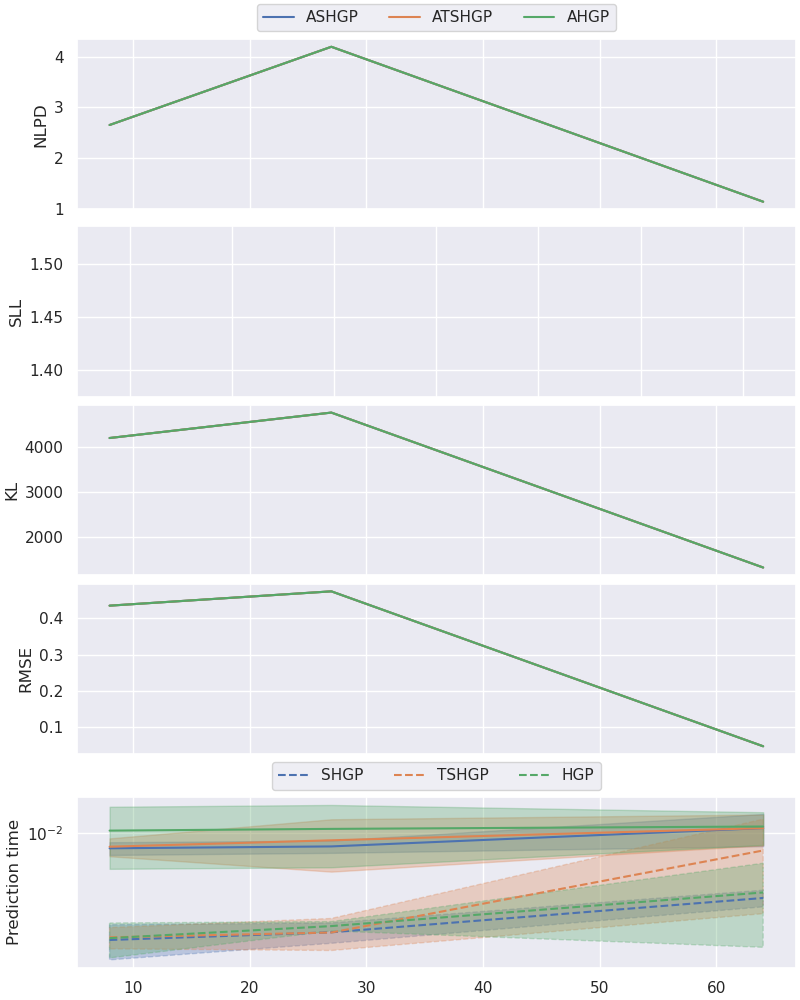

In [90]:
# m = 'SHGP'
metrics = ['NLPD', 'SLL', 'KL', 'RMSE', 'Prediction time']
plt.close("all")
fig, ax = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*2), constrained_layout=True)
for i, metric in enumerate(metrics):
    for m in models.keys(): 
        if 'time' in metric:
            mu, std = jnp.array([x.average for x in results[m][metric]]), jnp.array([x.stdev for x in results[m][metric]])
            # amu, astd = jnp.array([x.average for x in results['A' + m][metric]]), jnp.array([x.stdev for x in results['A' + m][metric]])
            # ax[i].plot(mi**3, amu/mu)
            l = ax[i].plot(mi**3, mu, ls='--', label=m)[0]
            ax[i].fill_between(mi**3, mu-3*std, mu+3*std, ls='--', color=l.get_color(), alpha=.3)
            mu, std = jnp.array([x.average for x in results['A' + m][metric]]), jnp.array([x.stdev for x in results['A' + m][metric]])
            ax[i].plot(mi**3, mu, color=l.get_color())[0]
            ax[i].fill_between(mi**3, mu-3*std, mu+3*std, color=l.get_color(), alpha=.3)
            ax[i].set(yscale="log")
        else:
            if metric not in ['RMSE', 'KL']:
                ax[i].plot(mi**3, results['A' + m][metric]/results[m][metric], label='A' + m)
            else:
                ax[i].plot(mi**3, results['A' + m][metric], label='A' + m)
    ax[i].set(ylabel=metric)
    if i < len(metrics)-1:
        ax[i].set(xticklabels=[])

ax[0].legend(ncols=3, bbox_to_anchor=(0.5, 1.0), loc="lower center")
ax[-1].legend(ncols=3, bbox_to_anchor=(0.5, 1.0), loc="lower center")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (14,) and (0,)

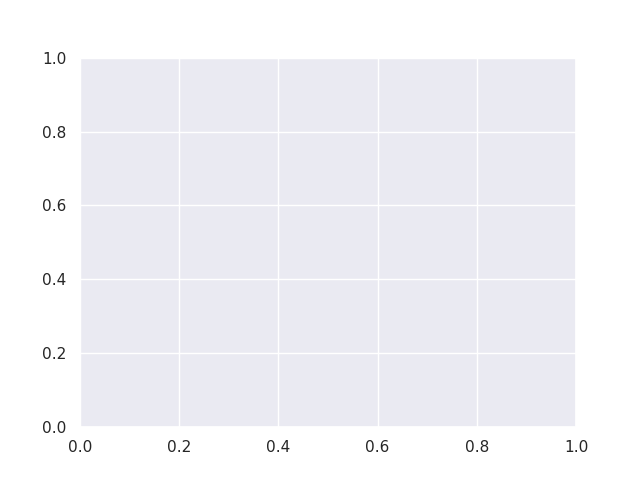

In [36]:
result = {}
for key, val in times.items():
    result[key] = {'mu': jnp.array([x.average for x in val]), 'std': jnp.array([x.stdev for x in val])}
plt.figure()
for key, val in result.items():
    l = plt.plot(mi**3, val['mu'])[0]
    plt.fill_between(mi**3, val['mu']-3*val['std'], val['mu']+3*val['std'], ls='--', color=l.get_color(), alpha=.3, label=key)
plt.yscale("log")
plt.legend()
plt.show()

In [20]:
posterior = prior * likelihood
key = jr.PRNGKey(13)
mll = gpx.objectives.ConjugateMLL(negative=True)
opt, history = gpx.fit(
    model=posterior,
    objective=mll,
    train_data=D,
    optim=ox.adam(learning_rate=1e-2),
    num_iters=250,
    safe=True,
    key=key,
)

  0%|          | 0/250 [00:00<?, ?it/s]

In [50]:
gp2 = gp.update_with_batch(D)
Tgp2 = Tgp.update_with_batch(D)

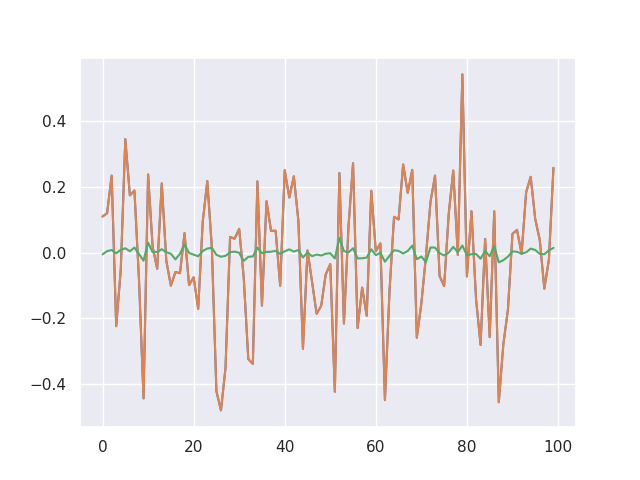

In [51]:
plt.close("all")
plt.figure()
plt.plot((y3d.squeeze() - gp2.predict(x3d).mean()))
plt.plot((y3d.squeeze() - Tgp2.predict(x3d).mean()))
plt.plot((y3d.squeeze() - opt.predict(x3d, D).mean()))
plt.show()

In [239]:
def compute_gamma(x, md, Ld):
    # Compute all possible unique k
    k = unique_k(md)
    # Compute all possible gammas
    return gamma(x, k, Ld)
unique_k = lambda md: jnp.array(list(product(*[jnp.arange(1-mi, 2*mi+1) for mi in md])))

In [11]:
# These guys just compute the information/dual matrix -- these aren't storage efficient
def T(x, i, j):
    """
    Given an i and j (which are respectively 1 x D), computes all possible permutations of j (which becomes k)
    k is thus a |p| x D matrix where |p| is the number of permutations
    Then, compute gamma for all k and multiply by the coefficients, which are themselves given by the product of p along the D dimension.
    """
    k = i + p * j
    c = jnp.prod(p, axis=1)
    return c @ (jnp.prod(1/Ls) * jnp.sum(vxgamma(x, Ls, k), axis=0))

def vT_upper(x, indices):
    """
    Computes the upper triangular part of I (the information/dual matrix).
    """
    # Creates an array with all possible permutations between indices (since I is symmetric we only need to compute the upper triangular part)
    # Assume a matrix A=[a1; a2; a3], combinations_with_replacement creates all possible combinations of a1, a2, a3, assuming that the combinations
    # are "symmetric". I.e., combinations_with_replacement(A) = [(a1, a1), (a1, a2), (a1, a3), (a2, a2), (a2, a3), (a3, a3)].
    # E.g., (a2, a1) is ignored because (a1, a2) exists.
    tmp = jnp.array(list(combinations_with_replacement(indices, 2)))
    i, j = tmp[:, 0], tmp[:, 1] # Extract the two index matrices
    # Vectorize the T simultaneously over i and j (i.e. it loops over i and j simultaneously, not independently)
    return jax.vmap(T, (None, 0, 0), 0)(x, i, j)

# Vectorized over i and j independently (this is inefficient!)
I = jax.vmap(jax.vmap(T, (None, 0, None), 0), (None, None, 0), 0)

# This is efficient! Only computes upper triangular part and then creates the symmetric matrix from that immediately
def I_new(x, indices):
    return sym(vT_upper(x, indices))

### Test the method on 3D data

Compare to just computing $\Phi^T \Phi$ naively.

In [242]:
# 3D test
indices = jnp.array(list(product(jnp.arange(1, ms[0]+1), jnp.arange(1, ms[1]+1), jnp.arange(1, ms[2]+1))))
p = jnp.array(list(product(*[[-1, 1]]*3))) # permutations

In [222]:
def get_slice(ks):
    # unique_k = [jnp.unique(x) for x in ks.T]
    # slices = []
    starts = []
    stops = []
    steps = []
    for kd in ks.T:
        start, stop = kd.min().astype(int), (kd.max() + 1).astype(int)
        step = jnp.diff(kd).max().astype(int)
        starts.append(start)
        stops.append(stop)
        steps.append(step)
        # slices.append((start, stop, step))
    # return tuple(slices)
    return [jnp.array(starts).astype(int), jnp.array(stops).astype(int), jnp.array(steps).astype(int)]

sl = get_slice((k1[0] - (1 - ms)))

### Comparison w/ standard computation

Within machine precision

In [357]:
from dataclasses import dataclass
from gpjax.base import param_field
@dataclass
class LaplaceBF(gpx.base.Module):
    num_bfs: list = param_field(default=[1], trainable=False)
    L: list = param_field(default=[1], trainable=False)
    center: list = param_field(default=[0], trainable=False)

    def __post_init__(self):
        self.j = jnp.array([jnp.arange(1, m + 1) for m in self.num_bfs])
        self.num_bfs = jnp.array(self.num_bfs)
        self.L = jnp.array(self.L)
        self.center = jnp.array(self.center)
        
    def _1d_call(self, x, j):
        z = x - self.center
        L = self.L
        op = jnp.pi * j * (z + L) / (2 * L)
        return jnp.prod(1 / jnp.sqrt(L) * jnp.sin(op) * (z >= -L) * (z <= L))

    def __call__(self, x):
        js = jnp.array(list(product(*[x.flatten() for x in jnp.split(bf.j, len(self.L))])))
        return jax.vmap(jax.vmap(self._1d_call, (None, 0), 0), (0, None), 0)(x, js)

    def eigenvalues(self):
        j = jnp.array(list(product(*self.j)))
        L = self.L
        lambda_j = ( jnp.pi * j / (2 * L) )**2
        return lambda_j.T

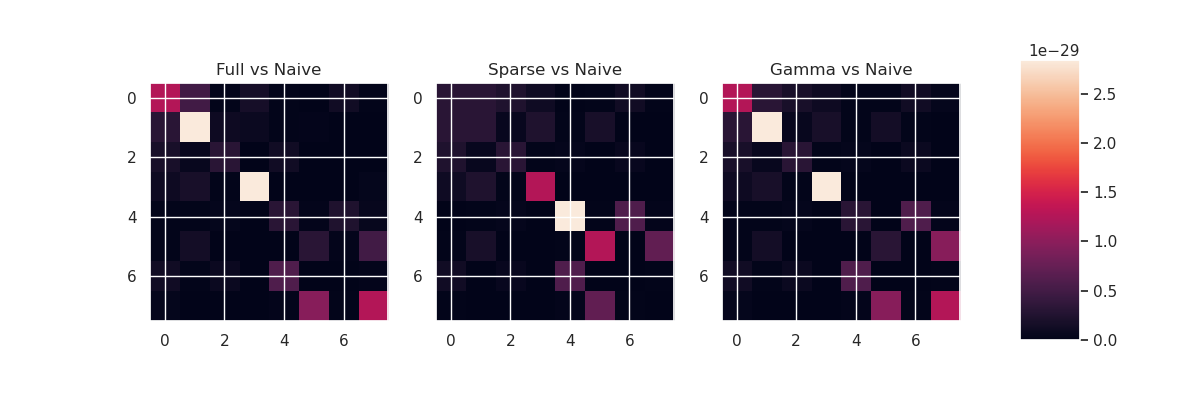

In [477]:
# Compare to standard computation
bf = LaplaceBF(ms, Ls, [0, 0, 0])
Phi = bf(x3d)
B = Phi.T@Phi
plt.close("all")
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
Ip = I(x3d, indices, indices)
Ip2 = I_new(x3d, indices)
Gamma = compute_gamma(x3d, ms, Ls) 
L = B_triu(Gamma, indices, ms, p)
Ip3 = sym(L)
e = (Ip-B)**2
ax[0].imshow(e, vmin=e.min(), vmax=e.max())
ax[0].set_title("Full vs Naive")
ax[1].imshow((Ip2-B)**2, vmin=e.min(), vmax=e.max())
ax[1].set_title("Sparse vs Naive")
g = ax[2].imshow((Ip3-B)**2, vmin=e.min(), vmax=e.max())
ax[2].set_title("Gamma vs Naive")
plt.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(g, cax=cbar_ax)
plt.show()

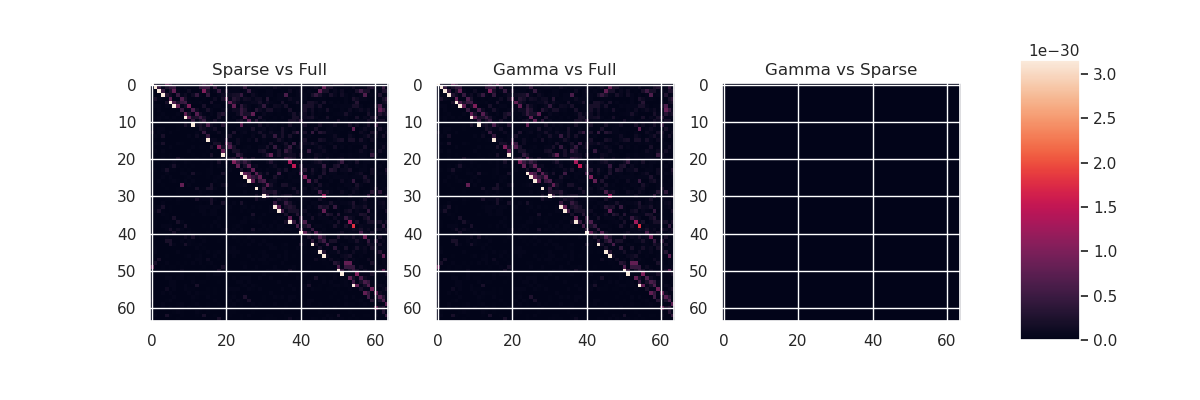

In [166]:
# Compare to standard computation
bf = LaplaceBF(ms, Ls, [0, 0, 0])
Phi = bf(x3d)
B = Phi.T@Phi
plt.close("all")
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
Ip = I(x3d, indices, indices)
Ip2 = I_new(x3d, indices)
Gamma = compute_gamma(x3d, ms, Ls) 
L = I_upper(Gamma, indices, ms)
Ip3 = sym(L)
e = (Ip2-Ip)**2
e2 = (Ip3-Ip)**2
e3 = (Ip3-Ip2)**2
ax[0].imshow(e, vmin=e.min(), vmax=e.max())
ax[0].set_title("Sparse vs Full")
ax[1].imshow(e2, vmin=e.min(), vmax=e.max())
ax[1].set_title("Gamma vs Full")
g = ax[2].imshow(e3, vmin=e.min(), vmax=e.max())
ax[2].set_title("Gamma vs Sparse")
plt.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(g, cax=cbar_ax)
plt.show()